# SimCLR 

Notebook based (partially) on the source code from: https://github.com/The-AI-Summer/simclr

## Imports

In [1]:
from utils.SimCLR import *

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked un

## Data

In [2]:
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)

print(f"Detected Device: {device}")

Detected Device: cuda


In [3]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)

## Plots

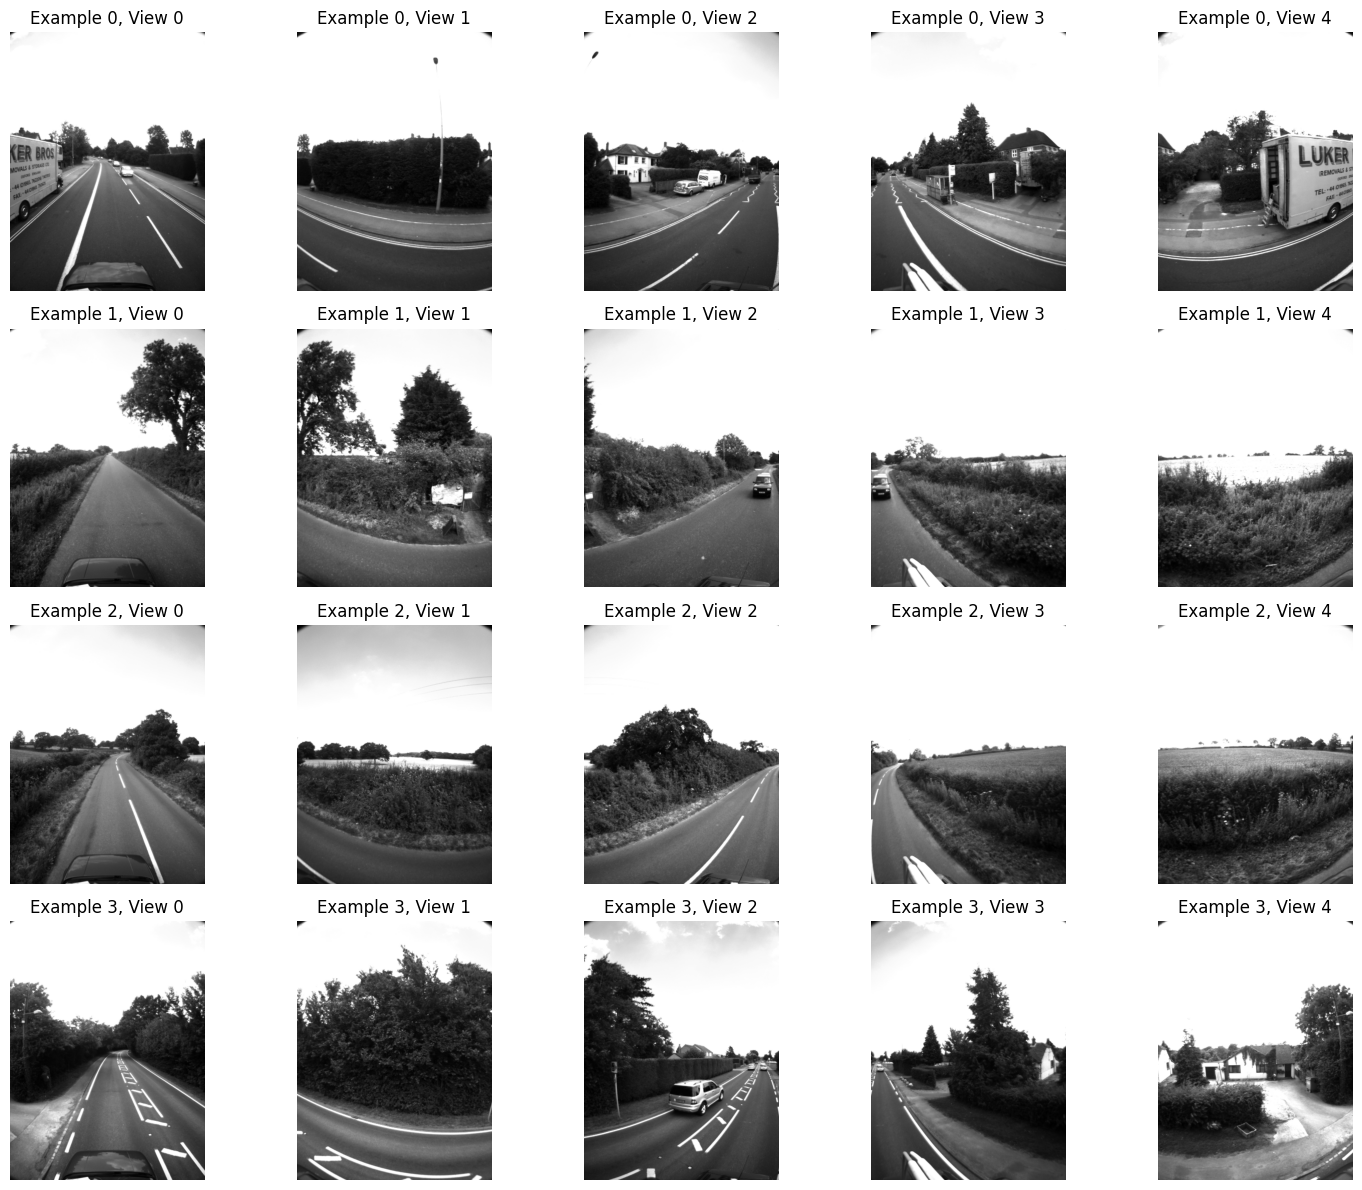

In [4]:
augmenter = Augment(img_size=224)
loader = get_data_loader(data_df, BATCH_SIZE, base_path='Eynsham/Images', transform=None, shuffle=True)
plot_sample_batch(loader, num_examples=4, num_views=5)

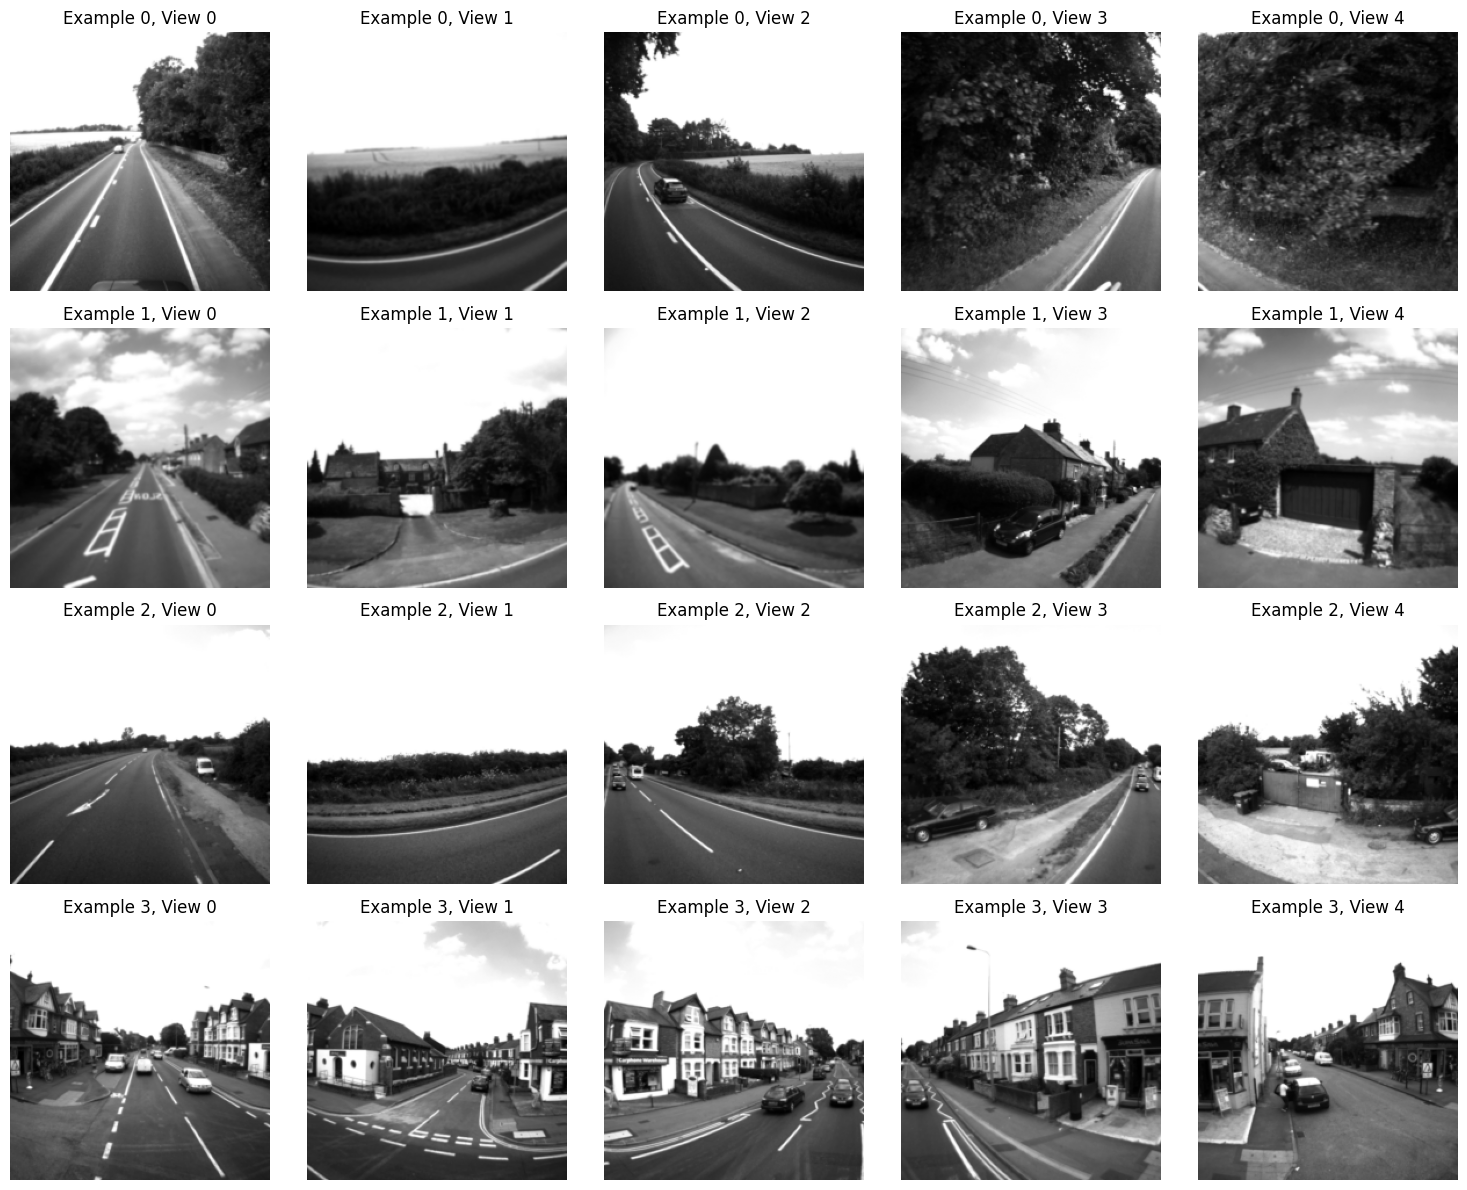

In [5]:
augmenter = Augment(img_size=224)
loader = get_data_loader(data_df, BATCH_SIZE, base_path='Eynsham/Images', transform=augmenter, shuffle=True)
plot_sample_batch(loader, num_examples=4, num_views=5)

## Large Embedding - 64

In [6]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)

In [7]:
model = SimCLR_pl(EMBEDDING_SIZE_LARGE, MLP_DIM)
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])

transform = Augment(img_size=224)
data_loader = get_data_loader(data_df, BATCH_SIZE, base_path='Eynsham/Images', transform=transform, shuffle=True)
accumulator = GradientAccumulationScheduler(scheduling={0: GRADIENT_ACCUMULATION_STEPS})
trainer = Trainer(callbacks=[accumulator],
                gpus=available_gpus,
                max_epochs=MAX_EPOCHS)

trainer.fit(model, data_loader)
model = model.to("cpu")
os.makedirs("models/", exist_ok=True)
model_path = "models/simclr_weights_large.pth"
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")
del model

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: F

Optimizer Adam, Learning Rate 0.0003, Effective batch size 320
Epoch 9: 100%|██████████| 71/71 [01:52<00:00,  1.59s/it, loss=2.92, v_num=13, Contrastive loss_step=0.489, Contrastive loss_epoch=3.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 71/71 [01:52<00:00,  1.59s/it, loss=2.92, v_num=13, Contrastive loss_step=0.489, Contrastive loss_epoch=3.050]
Model weights saved to models/simclr_weights_large.pth


### Results

In [8]:
model_path = "models/simclr_weights_large.pth"
model = SimCLR_pl(EMBEDDING_SIZE_LARGE, MLP_DIM)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [9]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df = data_df.head(250)

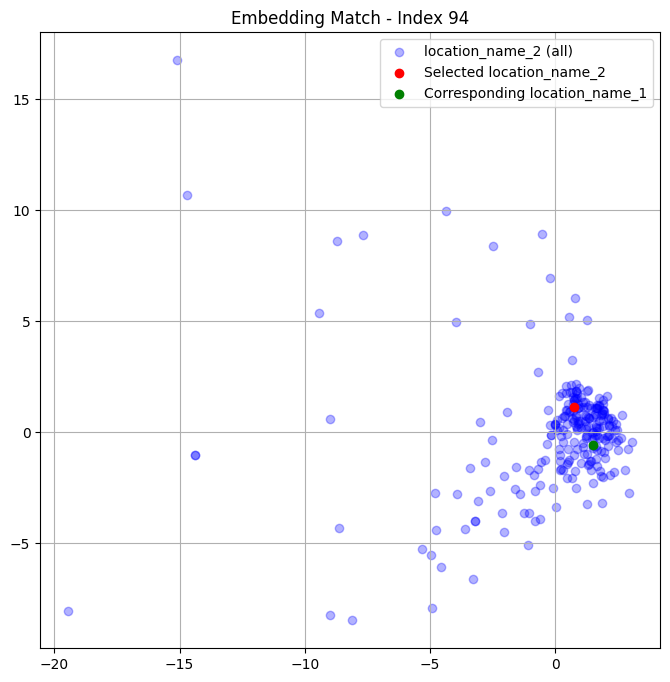

In [10]:
transform = TestAugment(img_size=224)
plot_embedding_match_2d(model, data_df.copy(), base_path='Eynsham/Images', device=device, batch_size=BATCH_SIZE, transform = transform)

In [11]:
top1small, top5small, top10small = evaluate_embedding_accuracy(model, data_df, base_path='Eynsham/Images', transform=transform)
print(f"Accuracy for concatenated embeddings NetVLAD: Top 1: {top1small*100:.4f}%, Top 5: {top5small*100:.4f}%, Top 10: {top10small*100:.4f}%")

Accuracy for concatenated embeddings NetVLAD: Top 1: 19.6000%, Top 5: 39.2000%, Top 10: 50.0000%


## Small Embedding - 2

In [12]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)

In [13]:
model = SimCLR_pl(EMBEDDING_SIZE_SMALL, MLP_DIM)
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])

transform = Augment(img_size=224)
data_loader = get_data_loader(data_df, BATCH_SIZE, base_path='Eynsham/Images', transform=transform, shuffle=True)
accumulator = GradientAccumulationScheduler(scheduling={0: GRADIENT_ACCUMULATION_STEPS})
trainer = Trainer(callbacks=[accumulator],
                gpus=available_gpus,
                max_epochs=MAX_EPOCHS)

trainer.fit(model, data_loader)
model = model.to("cpu")
os.makedirs("models/", exist_ok=True)
model_path = "models/simclr_weights_small.pth"
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")
del model

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: F

Optimizer Adam, Learning Rate 0.0003, Effective batch size 320
Epoch 9: 100%|██████████| 71/71 [01:42<00:00,  1.45s/it, loss=3.6, v_num=14, Contrastive loss_step=0.762, Contrastive loss_epoch=3.740] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 71/71 [01:43<00:00,  1.45s/it, loss=3.6, v_num=14, Contrastive loss_step=0.762, Contrastive loss_epoch=3.740]
Model weights saved to models/simclr_weights_small.pth


### Results

In [15]:
model_path = "models/simclr_weights_small.pth"
model = SimCLR_pl(EMBEDDING_SIZE_SMALL, MLP_DIM)
model.load_state_dict(torch.load(model_path))

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [16]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df = data_df.head(250)

tensor([[-0.4603, -1.3310]]) tensor([[-0.5995, -0.9327]])


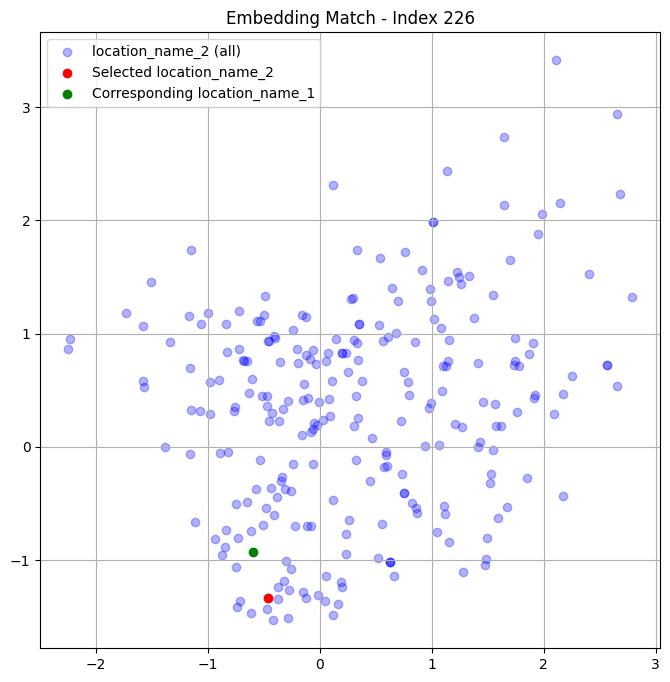

In [17]:
transform = TestAugment(img_size=224)
plot_embedding_match_2d(model, data_df, base_path='Eynsham/Images', transform=transform, use_pca=False)

In [18]:
top1small, top5small, top10small = evaluate_embedding_accuracy(model, data_df, base_path='Eynsham/Images', transform=transform)
print(f"Accuracy for concatenated embeddings NetVLAD: Top 1: {top1small*100:.4f}%, Top 5: {top5small*100:.4f}%, Top 10: {top10small*100:.4f}%")

Accuracy for concatenated embeddings NetVLAD: Top 1: 2.8000%, Top 5: 8.0000%, Top 10: 14.0000%
